In [1]:
#v3.classification
#17/8/2019
#modified augmentation approach to use albumentations: 
#https://github.com/albu/albumentations 
#https://albumentations.readthedocs.io/
# + {}
dataname="bladder_te_filt"
gpuid=0

# --- densenet params
#these parameters get fed directly into the densenet class, and more description of them can be discovered there
num_classes=2    #number of classes in the data mask that we'll aim to predict
in_channels= 3  #input channel of the data, RGB = 3


growth_rate=12
block_config=(2, 2, 2, 2)
num_init_features=64
bn_size=4
drop_rate=0



# --- training params
batch_size=128
patch_size=224 #currently, this needs to be 224 due to densenet architecture
num_epochs = 300
phases = ["train","val"] #how many phases did we create databases for?
validation_phases= ["val"] #when should we do valiation? note that validation is *very* time consuming, so as opposed to doing for both training and validation, we do it only for vlaidation at the end of the epoch
                           #additionally, using simply [], will skip validation entirely, drastically speeding things up
# + {}
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.models import DenseNet

from albumentations import *
from albumentations.pytorch import ToTensor


import PIL
import matplotlib.pyplot as plt
import cv2

import numpy as np
import sys, glob

from tensorboardX import SummaryWriter

import time
import math
import tables

import random

from sklearn.metrics import confusion_matrix


import scipy.ndimage
# -

#helper function for pretty printing of current time and remaining time
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)
def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent+.00001)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))


#specify if we should use a GPU (cuda) or only the CPU
print(torch.cuda.get_device_properties(gpuid))
torch.cuda.set_device(gpuid)
device = torch.device(f'cuda:{gpuid}' if torch.cuda.is_available() else 'cpu')

# +
#build the model according to the paramters specified above and copy it to the GPU. finally print out the number of trainable parameters
 
model = DenseNet(growth_rate=growth_rate, block_config=block_config,
                 num_init_features=num_init_features, 
                 bn_size=bn_size, 
                 drop_rate=drop_rate, 
                 num_classes=num_classes).to(device)
#model = DenseNet(growth_rate=32, block_config=(6, 12, 24, 16), #these represent the default parameters
#                 num_init_features=64, bn_size=4, drop_rate=0, num_classes=3)

print(f"total params: \t{sum([np.prod(p.size()) for p in model.parameters()])}")

_CudaDeviceProperties(name='TITAN X (Pascal)', major=6, minor=1, total_memory=12189MB, multi_processor_count=28)
total params: 	79784


In [2]:
#this defines our dataset class which will be used by the dataloader
class Dataset(object):
    def __init__(self, fname ,img_transform=None):
        #nothing special here, just internalizing the constructor parameters
        self.fname=fname

        self.img_transform=img_transform
        
        with tables.open_file(self.fname,'r') as db:
            self.classsizes=db.root.classsizes[:]
            self.nitems=db.root.imgs.shape[0]
        
        self.imgs = None
        self.labels = None
        
    def __getitem__(self, index):
        #opening should be done in __init__ but seems to be
        #an issue with multithreading so doing here. need to do it everytime, otherwise hdf5 crashes

        with tables.open_file(self.fname,'r') as db:
            self.imgs=db.root.imgs
            self.labels=db.root.labels

            #get the requested image and mask from the pytable
            img = self.imgs[index,:,:,:]
            label = self.labels[index]
        
        
        img_new = img
        
        if self.img_transform:
            img_new = self.img_transform(image=img)['image']

        return img_new, label, img
    def __len__(self):
        return self.nitems

# +
#https://github.com/albu/albumentations/blob/master/notebooks/migrating_from_torchvision_to_albumentations.ipynb
img_transform = Compose([
       VerticalFlip(p=.5),
       HorizontalFlip(p=.5),
       HueSaturationValue(hue_shift_limit=(20),sat_shift_limit=15,val_shift_limit=8,p=0.9),
#        Rotate(p=1, border_mode=cv2.BORDER_CONSTANT,value=0),
       #ElasticTransform(always_apply=True, approximate=True, alpha=150, sigma=8,alpha_affine=50),
       RandomSizedCrop((patch_size,patch_size), patch_size,patch_size),
       ToTensor()
    ])


dataset={}
dataLoader={}
for phase in phases: #now for each of the phases, we're creating the dataloader
                     #interestingly, given the batch size, i've not seen any improvements from using a num_workers>0
    
    dataset[phase]=Dataset(f"./{dataname}_{phase}.pytable", img_transform=img_transform)
    dataLoader[phase]=DataLoader(dataset[phase], batch_size=batch_size, 
                                shuffle=True, num_workers=8,pin_memory=True) 
    print(f"{phase} dataset size:\t{len(dataset[phase])}")


train dataset size:	34332
val dataset size:	10310


1


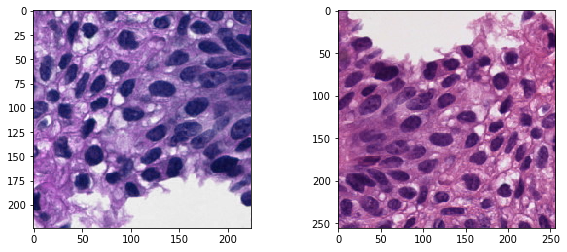

In [3]:
# +
#visualize a single example to verify that it is correct
(img, label, img_old)=dataset["train"][7]
fig, ax = plt.subplots(1,2, figsize=(10,4))  # 1 row, 2 columns

#build output showing patch after augmentation and original patch
ax[0].imshow(np.moveaxis(img.numpy(),0,-1))
ax[1].imshow(img_old)

print(label)

In [4]:
optim = torch.optim.Adam(model.parameters()) #adam is going to be the most robust, though perhaps not the best performing, typically a good place to start
# optim = torch.optim.SGD(model.parameters(),
#                           lr=.1,
#                           momentum=0.9,
#                           weight_decay=0.0005)

# +
#we have the ability to weight individual classes, in this case we'll do so based on their presense in the trainingset
#to avoid biasing any particular class
nclasses = dataset["train"].classsizes.shape[0]
class_weight=dataset["train"].classsizes
class_weight = torch.from_numpy(1-class_weight/class_weight.sum()).type('torch.FloatTensor').to(device)

print(class_weight) #show final used weights, make sure that they're reasonable before continouing
criterion = nn.CrossEntropyLoss(weight = class_weight) 

tensor([0.5250, 0.4750], device='cuda:0')


In [ ]:


# +
#def trainnetwork():
writer=SummaryWriter() #open the tensorboard visualiser
best_loss_on_test = np.Infinity

start_time = time.time()
for epoch in range(num_epochs):
    #zero out epoch based performance variables 
    all_acc = {key: 0 for key in phases} 
    all_loss = {key: torch.zeros(0).to(device) for key in phases} #keep this on GPU for greatly improved performance
    cmatrix = {key: np.zeros((num_classes,num_classes)) for key in phases}

    for phase in phases: #iterate through both training and validation states

        if phase == 'train':
            model.train()  # Set model to training mode
        else: #when in eval mode, we don't want parameters to be updated
            model.eval()   # Set model to evaluate mode

        for ii , (X, label, img_orig) in enumerate(dataLoader[phase]): #for each of the batches
            X = X.to(device)  # [Nbatch, 3, H, W]
            label = label.type('torch.LongTensor').to(device)  # [Nbatch, 1] with class indices (0, 1, 2,...num_classes)

            with torch.set_grad_enabled(phase == 'train'): #dynamically set gradient computation, in case of validation, this isn't needed
                                                            #disabling is good practice and improves inference time

                prediction = model(X)  # [N, Nclass]
                loss = criterion(prediction, label)


                if phase=="train": #in case we're in train mode, need to do back propogation
                    optim.zero_grad()
                    loss.backward()
                    optim.step()
                    train_loss = loss


                all_loss[phase]=torch.cat((all_loss[phase],loss.detach().view(1,-1)))

                if phase in validation_phases: #if this phase is part of validation, compute confusion matrix
                    p=prediction.detach().cpu().numpy()
                    cpredflat=np.argmax(p,axis=1).flatten()
                    yflat=label.cpu().numpy().flatten()

                    CM = scipy.sparse.coo_matrix((np.ones(yflat.shape[0], dtype=np.int64), (yflat, cpredflat)),
                        shape=(num_classes, num_classes), dtype=np.int64).toarray()
                    cmatrix[phase]=cmatrix[phase]+CM
#                     cmatrix[phase]=cmatrix[phase]+confusion_matrix(yflat,cpredflat, labels=range(nclasses))

        all_acc[phase]=(cmatrix[phase]/cmatrix[phase].sum()).trace()
        all_loss[phase] = all_loss[phase].cpu().numpy().mean()

        #save metrics to tensorboard
        writer.add_scalar(f'{phase}/loss', all_loss[phase], epoch)
        if phase in validation_phases:
            writer.add_scalar(f'{phase}/acc', all_acc[phase], epoch)
            for r in range(nclasses):
                for c in range(nclasses): #essentially write out confusion matrix
                    writer.add_scalar(f'{phase}/{r}{c}', cmatrix[phase][r][c],epoch)

    print('%s ([%d/%d] %d%%), train loss: %.4f test loss: %.4f' % (timeSince(start_time, (epoch+1) / num_epochs), 
                                                 epoch+1, num_epochs ,(epoch+1) / num_epochs * 100, all_loss["train"], all_loss["val"]),end="")    

    #if current loss is the best we've seen, save model state with all variables
    #necessary for recreation
    if all_loss["val"] < best_loss_on_test:
        best_loss_on_test = all_loss["val"]
        print("  **")
        state = {'epoch': epoch + 1,
         'model_dict': model.state_dict(),
         'optim_dict': optim.state_dict(),
         'best_loss_on_test': all_loss,
         'in_channels': in_channels,
         'growth_rate':growth_rate,
         'block_config':block_config,
         'num_init_features':num_init_features,
         'bn_size':bn_size,
         'drop_rate':drop_rate,
         'num_classes':num_classes}


        torch.save(state, f"{dataname}_densenet_best_model.pth")
    else:
        print("")


# +
# #%load_ext line_profiler
# #%lprun -f trainnetwork trainnetwork()

# +
#At this stage, training is done...below are snippets to help with other tasks: output generation + visualization 
# -

#----- generate output
#load best model
checkpoint = torch.load(f"{dataname}_densenet_best_model.pth")
model.load_state_dict(checkpoint["model_dict"])

#grab a single image from validation set
(img, label, img_old)=dataset["val"][2]

#generate its output
# #%%timeit
output=model(img[None,::].to(device))
output=output.detach().squeeze().cpu().numpy()
output.shape

print(output)
print(f"True class:{label}")
print(f"Predicted class:{np.argmax(output)}")

# +
#look at input
fig, ax = plt.subplots(1,2, figsize=(10,4))  # 1 row, 2 columns

ax[0].imshow(np.moveaxis(img.numpy(),0,-1))
ax[1].imshow(img_old)


# +
#------- visualize kernels and activations
# -

#helper function for visualization
def plot_kernels(tensor, num_cols=8 ,cmap="gray"):
    if not len(tensor.shape)==4:
        raise Exception("assumes a 4D tensor")
#    if not tensor.shape[1]==3:
#        raise Exception("last dim needs to be 3 to plot")
    num_kernels = tensor.shape[0] * tensor.shape[1]
    num_rows = 1+ num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols,num_rows))
    i=0
    t=tensor.data.numpy()
    for t1 in t:
        for t2 in t1:
            i+=1
            ax1 = fig.add_subplot(num_rows,num_cols,i)
            ax1.imshow(t2 , cmap=cmap)
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()


class LayerActivations():
    features=None
    def __init__(self,layer):
        self.hook = layer.register_forward_hook(self.hook_fn)
    def hook_fn(self,module,input,output):
        self.features = output.cpu()
    def remove(self):
        self.hook.remove()


# +
# --- visualize kernels
# -

w=model.features.denseblock2.denselayer1.conv2
plot_kernels(w.weight.detach().cpu()[0:5,0:5,:,:],5)

# +
# ---- visualize activiations
# -

dr=LayerActivations(model.features.denseblock2.denselayer1.conv2)

(img, label, img_old)=dataset["val"][7]
plt.imshow(np.moveaxis(img.numpy(),0,-1))
output=model(img[None,::].to(device))

plot_kernels(dr.features,8,cmap="rainbow")

# # ---- Improvements:
# 1 replace Adam with SGD with appropriate learning rate reduction



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


0m 53s (- 264m 57s) ([1/300] 0%), train loss: 0.3156 test loss: 1.7377  **
1m 44s (- 258m 37s) ([2/300] 0%), train loss: 0.1997 test loss: 2.5911
2m 35s (- 256m 41s) ([3/300] 1%), train loss: 0.1670 test loss: 1.6078  **
3m 27s (- 255m 49s) ([4/300] 1%), train loss: 0.1425 test loss: 2.3898
4m 19s (- 254m 45s) ([5/300] 1%), train loss: 0.1340 test loss: 1.3426  **
5m 10s (- 253m 30s) ([6/300] 2%), train loss: 0.1237 test loss: 2.4140
6m 2s (- 252m 26s) ([7/300] 2%), train loss: 0.1182 test loss: 1.2421  **
6m 53s (- 251m 29s) ([8/300] 2%), train loss: 0.1057 test loss: 2.5239
7m 45s (- 250m 32s) ([9/300] 3%), train loss: 0.1068 test loss: 2.1478
8m 36s (- 249m 32s) ([10/300] 3%), train loss: 0.1033 test loss: 2.6405
9m 29s (- 249m 7s) ([11/300] 3%), train loss: 0.0925 test loss: 2.6782
10m 20s (- 248m 4s) ([12/300] 4%), train loss: 0.0943 test loss: 2.4357
11m 12s (- 247m 24s) ([13/300] 4%), train loss: 0.0917 test loss: 3.0815
12m 4s (- 246m 46s) ([14/300] 4%), train loss: 0.0859 test

97m 45s (- 161m 46s) ([113/300] 37%), train loss: 0.0279 test loss: 1.9006
98m 37s (- 160m 54s) ([114/300] 38%), train loss: 0.0251 test loss: 4.7667
99m 29s (- 160m 2s) ([115/300] 38%), train loss: 0.0257 test loss: 2.9020
100m 21s (- 159m 10s) ([116/300] 38%), train loss: 0.0312 test loss: 2.6388
101m 14s (- 158m 20s) ([117/300] 39%), train loss: 0.0250 test loss: 3.3623
102m 6s (- 157m 28s) ([118/300] 39%), train loss: 0.0276 test loss: 4.7959
102m 58s (- 156m 36s) ([119/300] 39%), train loss: 0.0281 test loss: 2.0720
103m 50s (- 155m 44s) ([120/300] 40%), train loss: 0.0272 test loss: 1.5921
104m 42s (- 154m 52s) ([121/300] 40%), train loss: 0.0240 test loss: 3.0541
105m 33s (- 153m 59s) ([122/300] 40%), train loss: 0.0257 test loss: 1.6370
106m 25s (- 153m 8s) ([123/300] 41%), train loss: 0.0277 test loss: 1.7693
107m 18s (- 152m 17s) ([124/300] 41%), train loss: 0.0276 test loss: 2.2713
108m 10s (- 151m 25s) ([125/300] 41%), train loss: 0.0256 test loss: 1.9193
109m 1s (- 150m 33